# Latent Dirichlet Allocation

In [166]:
#Text Processing libraries
import nltk; nltk.download('stopwords'); nltk.download('punkt'); nltk.download('wordnet'); nltk.download('averaged_perceptron_tagger')
import re
from nltk.corpus import stopwords
import unicodedata

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/badewaaderogba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/badewaaderogba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/badewaaderogba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/badewaaderogba/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [167]:
#Load-data Libraries
import pandas as pd
import spacy
#loading tiny corpus
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

In [168]:
STOPWORD = nltk.corpus.stopwords.words('english')
STOPWORD.extend([ 'first', 'second', 'third', 'me', 'haha', 'lol', 'oof', 'cds', 'll', 've'])

In [169]:
data = pd.read_csv('data', sep=",", header=None)

data.columns = ['text']

data.head()

,text
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...
1,From: atterlep@vela.acs.oakland.edu (Cardinal ...
2,From: miner@kuhub.cc.ukans.edu\nSubject: Re: A...
3,From: atterlep@vela.acs.oakland.edu (Cardinal ...
4,From: vzhivov@superior.carleton.ca (Vladimir Z...


The data is a collection of emails that are not labelled. Let's try extract topics from them!

## Preprocessing 

👇 You're used to it by now... Clean up! Store the cleaned text in a new dataframe column "clean_text".

# . NLP:  prepocessing

In [170]:
def delete_accentchar(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x
def lema(x):
    """lemmatize"""
    
    x_list = []
    doc = nlp(x)
    
    for token in doc:
        lemma = str(token.lemma_)
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text
        x_list.append(lemma)
    return (" ".join(x_list))
#regex module,
def remove_num(clean_text):
    # remove numbers
    clean_textnonum = re.sub(r'\d+', '', clean_text)
    return clean_textnonum

In [171]:
data['clean_text'] =  data['text'].apply(lambda x: x.lower())
data['clean_text'] = data['clean_text'].apply(lambda x: re.sub('[^A-Z a-z 0-9-]+', '', x))
data['clean_text'] = data['clean_text'].apply(lambda x: " ".join(x.split()))
#data['clean_text'] = data['text'].apply(lambda x: re.sub(r"[^a-zA-Z0-9]"," ",x.lower().strip()))
data['clean_text'] = data['clean_text'].apply(lambda x: delete_accentchar(x))
data['clean_text'] = data['clean_text'].apply(lambda x: " ".join([w for w in x.split() if w not in STOPWORD]))
data['clean_text'] = data['clean_text'].apply(lambda x: lema(x))
data['clean_text']=data['clean_text'].apply(lambda x: remove_num(x))

In [172]:
data.head()

,text,clean_text
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,gldcunixbcccolumbiaedu gary l daresubject stan...
1,From: atterlep@vela.acs.oakland.edu (Cardinal ...,atterlepvelaacsoaklandedu cardinal ximenezsubj...
2,From: miner@kuhub.cc.ukans.edu\nSubject: Re: A...,minerkuhubccukansedusubject ancient booksorgan...
3,From: atterlep@vela.acs.oakland.edu (Cardinal ...,atterlepvelaacsoaklandedu cardinal ximenezsubj...
4,From: vzhivov@superior.carleton.ca (Vladimir Z...,vzhivovsuperiorcarletonca vladimir zhivovsubje...


In [173]:
#drop the text column
data = data.drop(['text'],axis=1)
data.columns = ["clean_text"]
data.head()

,clean_text
0,gldcunixbcccolumbiaedu gary l daresubject stan...
1,atterlepvelaacsoaklandedu cardinal ximenezsubj...
2,minerkuhubccukansedusubject ancient booksorgan...
3,atterlepvelaacsoaklandedu cardinal ximenezsubj...
4,vzhivovsuperiorcarletonca vladimir zhivovsubje...


In [120]:
#checking for misssing. no missing ...
data.isna().sum()

clean_text    0
dtype: int64

In [173]:
data['count']=data['clean_text'].apply(lambda x: len(str(x).split()))

Vectorizing: to convert the string data to numeric. I use Count vectorizer as the Latent Drichlet Allocation model has TD-IDF built in, hence I use Count vectorizer to avoid bad output.

In [183]:
#Vectorization:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
def get_bow(df,d,range_min,range_max,mindf,maxdf):
    
    cv = TfidfVectorizer()
    text_counts = cv.fit_transform(data['clean_text'])
    cv_df = pd.DataFrame(text_counts.toarray(), columns = cv.get_feature_names())#bow
    return cv,cv_df

In [184]:
text_counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [177]:
tfidf.idf_

array([5.38202663, 7.39692966, 7.39692966, ..., 6.99146455, 6.99146455,
       7.39692966])

In [185]:
cvectorizer,data_cv = get_bow(data,'clean_text',3,4,5,0.5)

## Latent Dirichlet Allocation model

👇 Train an LDA model to extract potential topics.

In [179]:
#model libraries modules
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [127]:
n_topics = 12
model_lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)
model_lda.fit_transform(text_count)

array([[0.00752299, 0.00752345, 0.00752335, ..., 0.0075243 , 0.00752289,
        0.34345048],
       [0.00750371, 0.03957028, 0.00749934, ..., 0.00749924, 0.00749924,
        0.00749997],
       [0.00719811, 0.00719913, 0.00719845, ..., 0.00719842, 0.07150646,
        0.00723772],
       ...,
       [0.00841208, 0.00841199, 0.00841199, ..., 0.00841199, 0.00841199,
        0.00841235],
       [0.0144844 , 0.01448415, 0.01448415, ..., 0.01448415, 0.01448415,
        0.09894715],
       [0.20998037, 0.00964287, 0.00964348, ..., 0.00964309, 0.00964338,
        0.00964571]])

In [188]:
'''
For each topic, we investigate the words occurrence  in the topic and their relative weight
'''
# Print the top 12 words per topic
n_words = 12
feature_names = cvectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model_lda.components_):
    print([(feature_names[i], topic[i].round(3)) for i in topic.argsort()[:-n_words -1:-1]])
    
    """top_features = ' '.join(top_n)
    
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx} \nwords: {top_features}".format(topic_idx, topic))
    print('\n\n\n')"""

[('god', 32.074), ('not', 30.581), ('would', 22.628), ('do', 21.268), ('say', 20.958), ('one', 20.62), ('people', 19.408), ('know', 18.726), ('think', 18.383), ('go', 17.9), ('jesus', 16.433), ('believe', 15.815)]
[('game', 18.278), ('player', 14.308), ('play', 13.225), ('team', 11.653), ('hockey', 10.268), ('goal', 8.689), ('leafs', 8.57), ('wing', 7.346), ('win', 7.329), ('toronto', 6.877), ('vs', 6.654), ('espn', 6.405)]
[('octopus', 1.309), ('proof', 1.125), ('terrance', 0.981), ('adirondack', 0.931), ('secretary', 0.917), ('watt', 0.911), ('suhonen', 0.877), ('generation', 0.874), ('dlmqccunyvmbitnet', 0.829), ('dab', 0.824), ('heathathenacsugaedu', 0.819), ('cape', 0.79)]
[('todd', 1.15), ('poll', 1.031), ('tiebreakerorganization', 0.784), ('willfutonwebodgcom', 0.784), ('partial', 0.772), ('ulf', 0.758), ('ra', 0.74), ('rich', 0.708), ('defensemen', 0.707), ('atnjd', 0.679), ('chef', 0.679), ('andexcellent', 0.679)]
[('georgia', 4.037), ('intelligence', 1.929), ('ai', 1.829), ('

## Visualize potential topics

👇 The function to print the words associated with the potential topics is already made for you. You just have to pass the correct arguments!

In [236]:
# Used LDA to look for 12 topics
n_topics = 12
model_lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)
model_lda.fit(data_cv)

# Print the top 10 words per topic
n_words = 10
feature_names = cvectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model_lda.components_):
    top_n = [feature_names[i]
              for i in topic.argsort()
               [-n_words:]][::-1]
    
    top_features = ' '.join(top_n)
    
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}:\nwords: {top_features}".format(topic_idx, topic))
    print('\n\n\n')
    
topic_result = model_lda.transform(data_cv)
data['topic']  = topic_result.argmax(axis=1)

Topic 0:
words: god not would do say one people know think go




Topic 1:
words: game player play team hockey goal leafs wing win toronto




Topic 2:
words: octopus proof terrance adirondack secretary watt suhonen generation dlmqccunyvmbitnet dab




Topic 3:
words: todd poll tiebreakerorganization willfutonwebodgcom partial ulf ra rich defensemen atnjd




Topic 4:
words: georgia intelligence ai ntmi athens mcovingtaiugaedu artificial amateur programs covingtonsubject




Topic 5:
words: cell canon reidcsuiucedu plymouth prophecy grogersslacvxslacstanfordedu sspx stanford cyt rturgeoozplymouthedu




Topic 6:
words: ttt legal chant sexual masterson foolish tounge maygenevarutgersedu melbourne gamespick




Topic 7:
words: fisher universitylines homosexuality realiability scofield act the salvation federko salami




Topic 8:
words: ahl pts disappointment huotcraycom jagr valerie tomb third kill tin




Topic 9:
words: absolute chi gtdaprismgatechedu europeans idacom pitt hrivnak dea

In [ ]:
'''
For each topic, we investigate the words occurrence  in the topic and their relative weight
'''
# Print the top 12 words per topic
n_words = 12
feature_names = cvectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model_lda.components_):
    print([(feature_names[i], topic[i].round(3)) for i in topic.argsort()[:-n_words -1:-1]])
    
    """top_features = ' '.join(top_n)
    
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx} \nwords: {top_features}".format(topic_idx, topic))
    print('\n\n\n')"""

In [237]:
def top_n_gram(corpus,r, n=None):
    vec = CountVectorizer(ngram_range=(r, r), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [200]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [243]:
common_words = top_n_gram(data['clean_text'], 1, 50)

tdf = pd.DataFrame(common_words, columns = ['clean_text' , 'count'])
tdf.groupby('clean_text').sum()['count'].sort_values(ascending=False).iplot(kind='bar', 
                                                                            yTitle='Count', 
                                                                            linecolor='green', 
                                                                            title='Top 50 unigrams');


In [244]:
#biagram
common_words = top_n_gram(data['clean_text'], 2, 50)

tdf = pd.DataFrame(common_words, columns = ['clean_text' , 'count'])
tdf.groupby('clean_text').sum()['count'].sort_values(ascending=False).iplot(kind='bar', 
                                                                            yTitle='Count', 
                                                                            linecolor='green', 
                                                                            title='Top 50 bigrams');                                                                          

In [245]:
#trigram
common_words = top_n_gram(data['clean_text'], 3, 50)

tdf = pd.DataFrame(common_words, columns = ['clean_text' , 'count'])
tdf.groupby('clean_text').sum()['count'].sort_values(ascending=False).iplot(kind='bar', 
                                                                            yTitle='Count', 
                                                                            linecolor='green', 
                                                                            title='Top 50 trigrams');

In [246]:
#4grams
common_words = top_n_gram(data['clean_text'], 4, 50)
    
tdf = pd.DataFrame(common_words, columns = ['clean_text' , 'count'])
tdf.groupby('clean_text').sum()['count'].sort_values(ascending=False).iplot(kind='bar', 
                                                                            yTitle='Count', 
                                                                            linecolor='green', 
                                                                            title='Top 50 4-grams')

Observation:most of the word revolve around sport, education and religion

In [205]:
# Used LDA to look for 12 topics
n_topics = 12
model_lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)
model_lda.fit(data_cv)

# Print the top 10 words per topic
n_words = 10
feature_names = cvectorizer.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model_lda.components_):
    top_n = [feature_names[i]
              for i in topic.argsort()
               [-n_words:]][::-1]
    
    top_features = ' '.join(top_n)
    
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")
    print('\n\n\n')
    
topic_result = model_lda.transform(data_cv)
data['topic']  = topic_result.argmax(axis=1)

Topic 0: god not would do say one people know think go




Topic 1: game player play team hockey goal leafs wing win toronto




Topic 2: octopus proof terrance adirondack secretary watt suhonen generation dlmqccunyvmbitnet dab




Topic 3: todd poll tiebreakerorganization willfutonwebodgcom partial ulf ra rich defensemen atnjd




Topic 4: georgia intelligence ai ntmi athens mcovingtaiugaedu artificial amateur programs covingtonsubject




Topic 5: cell canon reidcsuiucedu plymouth prophecy grogersslacvxslacstanfordedu sspx stanford cyt rturgeoozplymouthedu




Topic 6: ttt legal chant sexual masterson foolish tounge maygenevarutgersedu melbourne gamespick




Topic 7: fisher universitylines homosexuality realiability scofield act the salvation federko salami




Topic 8: ahl pts disappointment huotcraycom jagr valerie tomb third kill tin




Topic 9: absolute chi gtdaprismgatechedu europeans idacom pitt hrivnak dean vs selnne




Topic 10: breaker prophecy francis po tie robbie howl 

In [206]:
topic

array([0.08333333, 0.08333333, 0.08333333, ..., 0.08333333, 0.08333333,
       0.25729443])

In [207]:
   
topic_result = model_lda.transform(data_cv)
data['topic']  = topic_result.argmax(axis=1)

In [289]:
#plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#from plotly.offline import init_notebook_mode, iplot
#init_notebook_mode(connected=True)


A look at the wordcloud of all the topics to get a better idea of which topic given by the LDA suits best with the offered topic

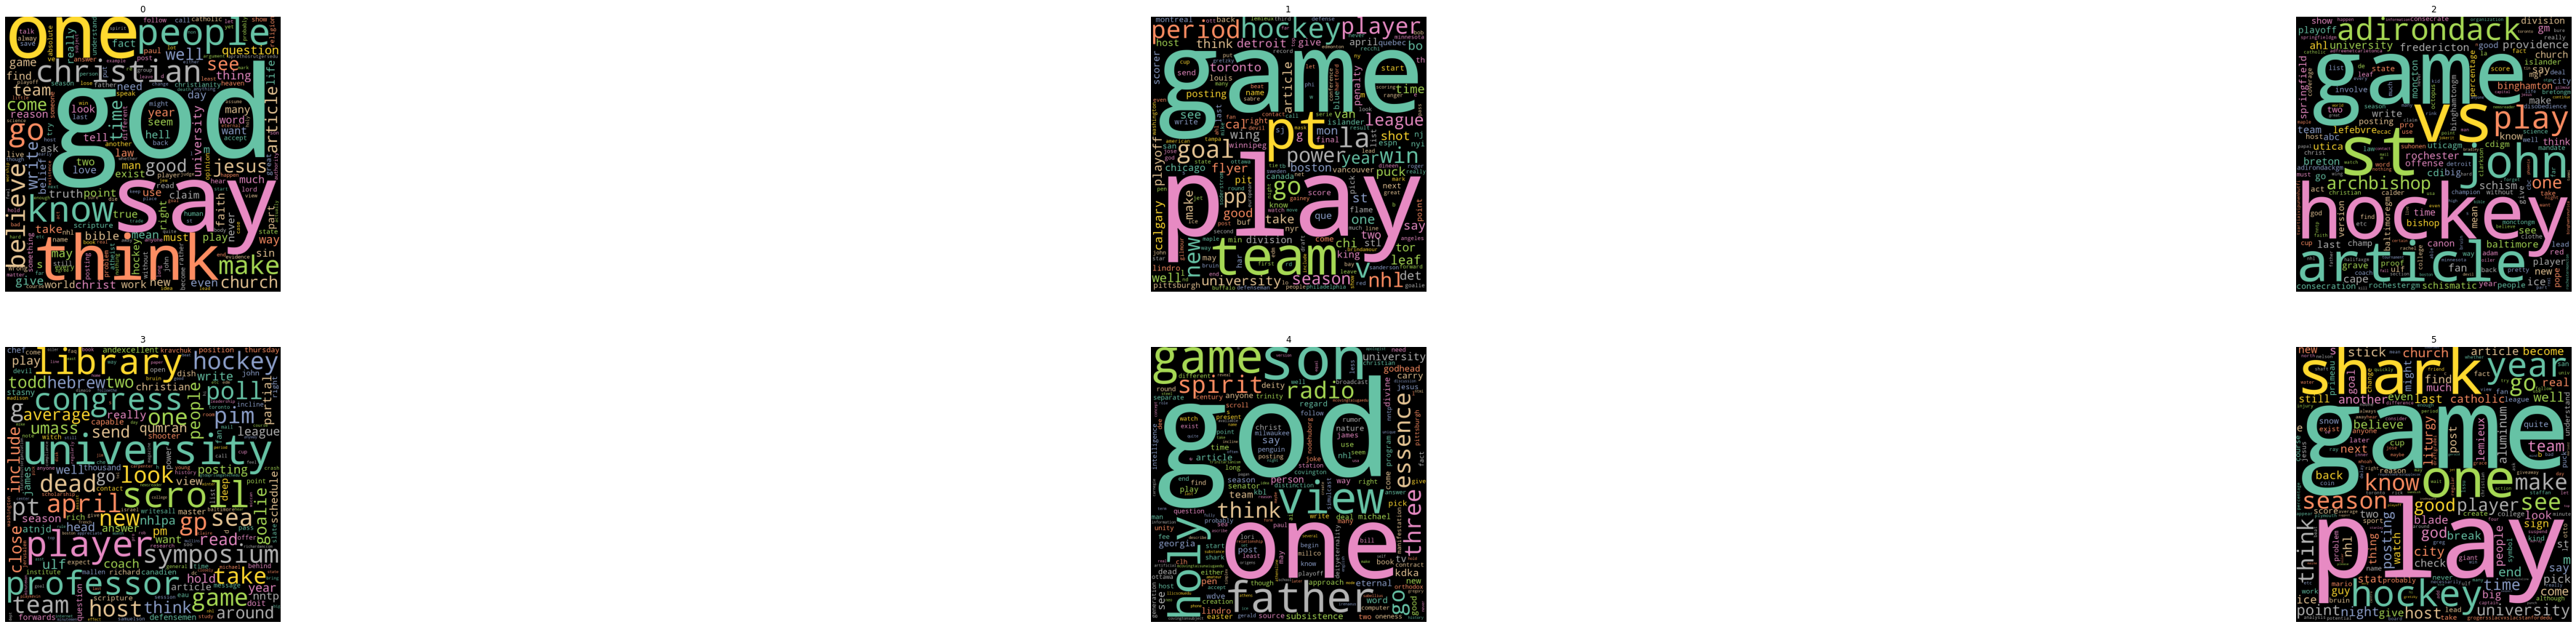

In [247]:
fig = plt.figure(figsize=(80,32))
for i in range(6):
    ax = fig.add_subplot(4,3,i+1)
    topic = i
    text = ' '.join(data.loc[data['topic']==i,'clean_text'].values)
    wc = WordCloud(width=1000, 
                   height=1000, 
                   random_state=1, 
                   background_color='Black',
                   colormap='Set2',
                   collocations=False).generate(text)
    ax.imshow(wc)
    ax.set_title(topic)
    ax.axis("off");

Next we observe which topics are distributed in which way, this is vital as we have to build a classifier based on this

In [209]:
data.groupby('topic').count()['clean_text'].iplot(kind='bar', 
                                              yTitle='Count', 
                                              linecolor='black', 
                                              opacity=0.8,
                                              title='Bar chart of Topic Name',
                                              xTitle='Topic Name')

## Predict topic of new text

👇 You can now use your LDA model to predict the topic of a new text. First, use your vectorizer to vectorize the example. Then, use your LDA model to predict the topic of the vectorized example.

In [210]:
#encoding
df=data[['clean_text','topic']]
df = pd.get_dummies(df, columns=['topic'])

In [211]:
df

,clean_text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11
0,gldcunixbcccolumbiaedu gary l daresubject stan...,1,0,0,0,0,0,0,0,0,0,0,0
1,atterlepvelaacsoaklandedu cardinal ximenezsubj...,1,0,0,0,0,0,0,0,0,0,0,0
2,minerkuhubccukansedusubject ancient booksorgan...,1,0,0,0,0,0,0,0,0,0,0,0
3,atterlepvelaacsoaklandedu cardinal ximenezsubj...,1,0,0,0,0,0,0,0,0,0,0,0
4,vzhivovsuperiorcarletonca vladimir zhivovsubje...,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,jerrybeskimocom jerry kaufmansubject prayer ad...,0,0,0,0,0,0,0,0,0,0,0,1
1195,golchowyalchemychemutorontoca gerald olchowysu...,0,0,1,0,0,0,0,0,0,0,0,0
1196,jaynemmaltguildorg jayne kulikauskassubject qu...,1,0,0,0,0,0,0,0,0,0,0,0
1197,sclarkepasutorontoca susan clarksubject pick f...,0,0,0,0,0,0,0,1,0,0,0,0


In [212]:
#splitting the data
TRAIN, TEST = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

x_train = TRAIN.clean_text
x_test = TEST.clean_text

#print the shape

print(x_train.shape)
print(x_test.shape)

(803,)
(396,)


In [213]:
import sklearn
print(sklearn.__version__)

0.24.2


In [217]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.multiclass import OneVsRestClassifier
# Define a pipeline combining a text feature extractor with multi lable classifier
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=STOPWORD)),
                ('smote', SMOTE(random_state=12)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),])


In [218]:
classes = ['topic_0', 
              'topic_1',
              'topic_2', 
              'topic_3', 
              'topic_4', 
              'topic_5',
              'topic_6',
              'topic_7',
              'topic_8',
              'topic_9',
              'topic_10',
              'topic_11']

In [229]:
#evaluating the model
#accuracy, precision, recall
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
for category in classes:
    print('... preprocessing {}'.format(category))

    pipeline.fit(x_train, TRAIN[category])#train pipeline

    prediction = pipeline.predict(x_test)#testing the pipeline using trained model
    accuracy = accuracy_score(TEST[category], prediction)
    print('Test accuracy in percentage is:', round(accuracy, 2)*100)

    

... preprocessing topic_0
Test accuracy in percentage is: 77.0
... preprocessing topic_1
Test accuracy in percentage is: 69.0
... preprocessing topic_2
Test accuracy in percentage is: 93.0
... preprocessing topic_3
Test accuracy in percentage is: 98.0
... preprocessing topic_4
Test accuracy in percentage is: 96.0
... preprocessing topic_5
Test accuracy in percentage is: 95.0
... preprocessing topic_6
Test accuracy in percentage is: 97.0
... preprocessing topic_7
Test accuracy in percentage is: 95.0
... preprocessing topic_8
Test accuracy in percentage is: 84.0
... preprocessing topic_9
Test accuracy in percentage is: 89.0
... preprocessing topic_10
Test accuracy in percentage is: 93.0
... preprocessing topic_11
Test accuracy in percentage is: 96.0


In [231]:
print("Other Metrics:")
print(classification_report(TEST[category], prediction))


Other Metrics:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       384
           1       0.36      0.33      0.35        12

    accuracy                           0.96       396
   macro avg       0.67      0.66      0.66       396
weighted avg       0.96      0.96      0.96       396



In [233]:
#
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

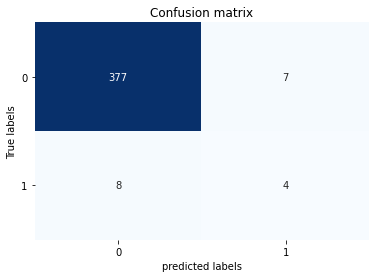

In [234]:
## Plot confusion matrix
from sklearn.metrics import confusion_matrix
classes = np.unique(TEST[category])

cm = confusion_matrix(TEST[category], prediction)
fig, ax = plt.subplots()

sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="predicted labels", ylabel="True labels", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

Observation:We can see that we have 7 False negative and 4 True Negative. While True Positive = 377 and False Positive = 8 which is not bad. Our accuracy seems not bad

In [232]:
#save the model
import pickle

file_name = 'Npipelinemodel'
pickle.dump(pipeline, open(file_name, 'wb'))